In [0]:
# Access keys config
spark.conf.set("fs.s3a.access.key", "XXXXXXXXXXXXXXXXXX")
spark.conf.set("fs.s3a.secret.key", "YYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYYY")
spark.conf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
spark.conf.set("fs.s3a.endpoint", "s3.amazonaws.com")
spark.conf.set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")


#### Reading data from silver layer bucket

In [0]:
payments_df = spark.read.option("header", "true").parquet("s3://ecommerce-sales-project/silver/payments_processed")
products_df = spark.read.option("header", "true").parquet("s3://ecommerce-sales-project/silver/products_processed")
sellers_df = spark.read.option("header", "true").parquet("s3://ecommerce-sales-project/silver/sellers_processed")
orders_df = spark.read.option("header", "true").parquet("s3://ecommerce-sales-project/silver/orders_processed")
order_items_df = spark.read.option("header", "true").parquet("s3://ecommerce-sales-project/silver/order_items_processed")
customers_df = spark.read.option("header", "true").parquet("s3://ecommerce-sales-project/silver/customers_processed")


#### Creating combined dataframes for golden layer

In [0]:
#creating orders combined df
total_orders_df = order_items_df.join(orders_df, order_items_df.order_id == orders_df.order_id, "inner") \
                                .join(sellers_df, order_items_df.seller_id == sellers_df.seller_id, "inner") \
                                .select(orders_df['*'], \
                                order_items_df['order_item_id'], order_items_df['product_id'], order_items_df['seller_id'], \
                                order_items_df['price'], order_items_df['freight_value'], order_items_df['total_price'])
items_customers_df = orders_df.join(customers_df, orders_df.customer_id == customers_df.customer_id, "inner")
final_orders_df = total_orders_df.join(items_customers_df, total_orders_df.order_id == items_customers_df.order_id, "inner") \
                                 .select(total_orders_df['*'], \
                                  items_customers_df['customer_unique_id'], items_customers_df['zip_code'], \
                                  items_customers_df['customer_city'], items_customers_df['customer_state'])

In [0]:
#creating products and payments combined df:
final_product_payments_df = order_items_df.join(products_df, order_items_df.product_id == products_df.product_id) \
                                          .join(payments_df, order_items_df.order_id == payments_df.order_id) \
                                          .select(order_items_df['*'], \
                                           products_df['product_category'], products_df['product_weight_g'], products_df['product_length_cm'], products_df['product_height_cm'],products_df['product_width_cm'], \
                                           payments_df['payment_sequential'], payments_df['payment_type'], payments_df['payment_installments'], payments_df['payment_value'], payments_df['payment_processing_time'])

In [0]:
#saving to the golden layer

final_orders_df.write.mode("overwrite").parquet("s3://ecommerce-sales-project/gold/final_orders_df")
final_product_payments_df.write.mode("overwrite").parquet("s3://ecommerce-sales-project/gold/final_product_payments_df")


#### Extraction of selected aggregations

In [0]:
#finding the product with the largest dimensions

from pyspark.sql.functions import concat, lit, col

products_new_df = products_df.withColumn("measures [l x h x w]", \
                              concat(col("product_length_cm"), lit(" x "), \
                              col("product_height_cm"), lit(" x "), col("product_width_cm"))) \
                              .withColumn("total_surface[cm^3]", col("product_length_cm") * col("product_height_cm") * col("product_width_cm"))

biggest_product_df = products_new_df.select("product_id", "product_category", "measures [l x h x w]", "total_surface[cm^3]") \
                                    .orderBy(col('total_surface[cm^3]').desc())

packet_locker_df = biggest_product_df.filter(biggest_product_df['total_surface[cm^3]'] < 150000)

biggest_toys_df = biggest_product_df.filter((biggest_product_df['total_surface[cm^3]'] < 150000) & (biggest_product_df['product_category'] == 'TOYS'))

In [0]:
biggest_product_df.show(5)

+--------------------+--------------------+--------------------+-------------------+
|          product_id|    product_category|measures [l x h x w]|total_surface[cm^3]|
+--------------------+--------------------+--------------------+-------------------+
|256a9c364b75753b9...|          HOUSEWARES|        68 x 66 x 66|             296208|
|c1e0531cb1864fd3a...|      ROOM FURNITURE|        70 x 60 x 70|             294000|
|f227e2d44f10f7dad...|      ROOM FURNITURE|        70 x 60 x 70|             294000|
|0b48eade13cfad433...|FURNITURE DECORATION|        70 x 60 x 70|             294000|
|3eb14e65e4208c6d9...|      ROOM FURNITURE|        70 x 60 x 70|             294000|
+--------------------+--------------------+--------------------+-------------------+
only showing top 5 rows



In [0]:
packet_locker_df.show(5)

+--------------------+----------------+--------------------+-------------------+
|          product_id|product_category|measures [l x h x w]|total_surface[cm^3]|
+--------------------+----------------+--------------------+-------------------+
|50fb810523dcd3bd2...|            TOYS|        57 x 73 x 36|             149796|
|5f82c0dd37c20e3f5...|      HOUSEWARES|        48 x 65 x 48|             149760|
|3ce21e38e6a3060c2...|          BABIES|        62 x 43 x 56|             149296|
|ace8fb267a4f76c58...|            null|        65 x 79 x 29|             148915|
|3150c2690393e7ea7...|          BABIES|        37 x 77 x 52|             148148|
+--------------------+----------------+--------------------+-------------------+
only showing top 5 rows



In [0]:
biggest_toys_df.show(5)

+--------------------+----------------+--------------------+-------------------+
|          product_id|product_category|measures [l x h x w]|total_surface[cm^3]|
+--------------------+----------------+--------------------+-------------------+
|50fb810523dcd3bd2...|            TOYS|        57 x 73 x 36|             149796|
|0cd7885ebb79eda16...|            TOYS|        65 x 40 x 54|             140400|
|561bea95142a07c5a...|            TOYS|        32 x 82 x 52|             136448|
|03fed41c5e9067007...|            TOYS|        75 x 76 x 22|             125400|
|ef95321bde02d8afc...|            TOYS|        56 x 76 x 27|             114912|
+--------------------+----------------+--------------------+-------------------+
only showing top 5 rows



In [0]:
#finding the most expensive orders
least_expensive_df = order_items_df.select("order_id", "product_id", "price", "freight_value", "total_price") \
                                   .orderBy("total_price")

most_expensive_df = order_items_df.select("order_id", "product_id", "price", "freight_value", "total_price") \
                                  .orderBy(col("total_price").desc())

least_expensive_df.show(5)
most_expensive_df.show(5)

+--------------------+--------------------+-----+-------------+-----------+
|            order_id|          product_id|price|freight_value|total_price|
+--------------------+--------------------+-----+-------------+-----------+
|8fbcb92faf1aa6036...|adc48fd26eea311ca...|  4.4|         1.68|       6.08|
|8fbcb92faf1aa6036...|adc48fd26eea311ca...|  4.4|         1.68|       6.08|
|8fbcb92faf1aa6036...|adc48fd26eea311ca...|  4.4|         1.68|       6.08|
|8fbcb92faf1aa6036...|adc48fd26eea311ca...|  4.4|         1.68|       6.08|
|71e22e2d99081d6dc...|ac480ada5f06d9024...|  7.0|         0.28|       7.28|
+--------------------+--------------------+-----+-------------+-----------+
only showing top 5 rows

+--------------------+--------------------+------+-------------+-----------+
|            order_id|          product_id| price|freight_value|total_price|
+--------------------+--------------------+------+-------------+-----------+
|0812eb902a67711a1...|489ae2aa008f02150...|6735.0|       194

In [0]:
#transactions quantity per day
from pyspark.sql.functions import to_date, count

transactions_qty_df = orders_df.select(to_date(col("order_purchase_date")).alias("order_date")) \
                                .groupBy("order_date") \
                                .agg(count('*').alias("qty")) \
                                .orderBy(col("qty").desc())

transactions_qty_df.show(5)

+----------+----+
|order_date| qty|
+----------+----+
|2017-11-24|1176|
|2017-11-25| 499|
|2017-11-27| 403|
|2017-11-26| 391|
|2017-11-28| 380|
+----------+----+
only showing top 5 rows



In [0]:
#sum of transactions (month by month)
from pyspark.sql.functions import month, year

by_month_df = orders_df.select(year(to_date(col("order_purchase_date"))).alias("year"), \
                               month(to_date(col("order_purchase_date"))).alias("month")) \
                        .groupBy("year", "month") \
                        .agg(count("*").alias("qty")) \
                        .orderBy("year", "month")

by_month_df.show(10)

+----+-----+----+
|year|month| qty|
+----+-----+----+
|2016|    9|   4|
|2016|   10| 324|
|2016|   12|   1|
|2017|    1| 800|
|2017|    2|1780|
|2017|    3|2682|
|2017|    4|2404|
|2017|    5|3700|
|2017|    6|3245|
|2017|    7|4026|
+----+-----+----+
only showing top 10 rows



In [0]:
#number of undelivered packages per year

undelivered_df = orders_df.select(year(to_date(col("order_purchase_date"))).alias("year"), "order_status") \
                          .groupBy("year", "order_status") \
                          .agg(count('*').alias("qty")) \
                          .orderBy("year", col("qty").desc())

undelivered_df.show(10)

+----+------------+-----+
|year|order_status|  qty|
+----+------------+-----+
|2016|   delivered|  267|
|2016|    canceled|   26|
|2016|     delayed|   18|
|2016|     shipped|    9|
|2016| unavailable|    7|
|2016|  processing|    2|
|2017|   delivered|43428|
|2017|     shipped|  530|
|2017| unavailable|  457|
|2017|    canceled|  265|
+----+------------+-----+
only showing top 10 rows



In [0]:
#rank of best destinations
from pyspark.sql.functions import rank, desc
from pyspark.sql.window import Window

best_dest_df = customers_df.select("customer_state", "customer_city") \
                           .groupBy("customer_state", "customer_city") \
                           .agg(count("*").alias("qty"))

window_spec = Window.partitionBy("customer_state").orderBy(desc("qty"))

rank_of_dest_df = best_dest_df.withColumn("rank", rank().over(window_spec))

rank_of_dest_df.show(15)

+--------------+-------------------+---+----+
|customer_state|      customer_city|qty|rank|
+--------------+-------------------+---+----+
|            AC|         rio branco| 70|   1|
|            AC|    cruzeiro do sul|  3|   2|
|            AC|             xapuri|  2|   3|
|            AC|   senador guiomard|  2|   3|
|            AC|     epitaciolandia|  1|   5|
|            AC|          brasileia|  1|   5|
|            AC|         porto acre|  1|   5|
|            AC|      manoel urbano|  1|   5|
|            AL|             maceio|247|   1|
|            AL|          arapiraca| 29|   2|
|            AL|    teotonio vilela|  8|   3|
|            AL|             penedo|  8|   3|
|            AL|palmeira dos indios|  8|   3|
|            AL|          rio largo|  6|   6|
|            AL|           maragogi|  5|   7|
+--------------+-------------------+---+----+
only showing top 15 rows




#### Plots

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

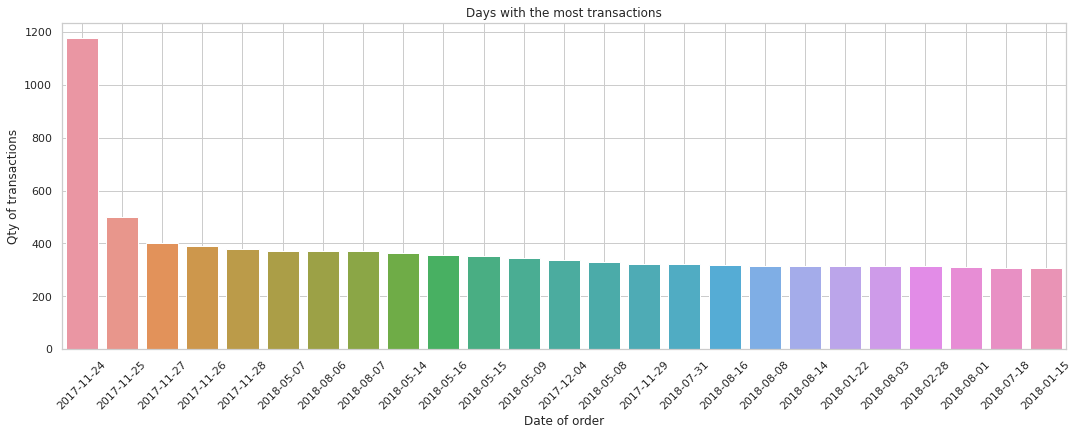

In [0]:
#most transactions per day
transactions_qty_pd_df = transactions_qty_df.toPandas()
transactions_qty_pd_df = transactions_qty_pd_df.sort_values(by='qty', ascending=False).head(25)

plt.figure(figsize=(18, 6))
sns.barplot(data=transactions_qty_pd_df, x='order_date', y='qty')

plt.xlabel('Date of order')
plt.ylabel('Qty of transactions')
plt.title('Days with the most transactions')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

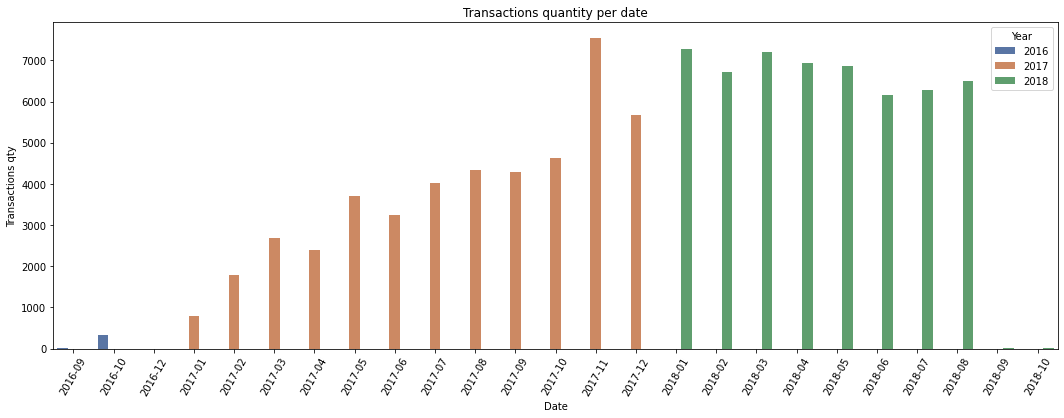

In [0]:
#sum of transactions (month by month)
by_month_pd_df = by_month_df.toPandas()
by_month_pd_df['year_month'] = by_month_pd_df['year'].astype(str) + '-' + by_month_pd_df['month'].astype(str).str.zfill(2)

x = by_month_pd_df['year_month']
y = by_month_pd_df['qty']

plt.figure(figsize=(18, 6))
sns.barplot(data=by_month_pd_df, x='year_month', y='qty', hue='year', palette='deep')

plt.xlabel('Date')
plt.ylabel('Transactions qty')
plt.title('Transactions quantity per date')
plt.xticks(rotation=60)
plt.legend(title='Year')

plt.show()

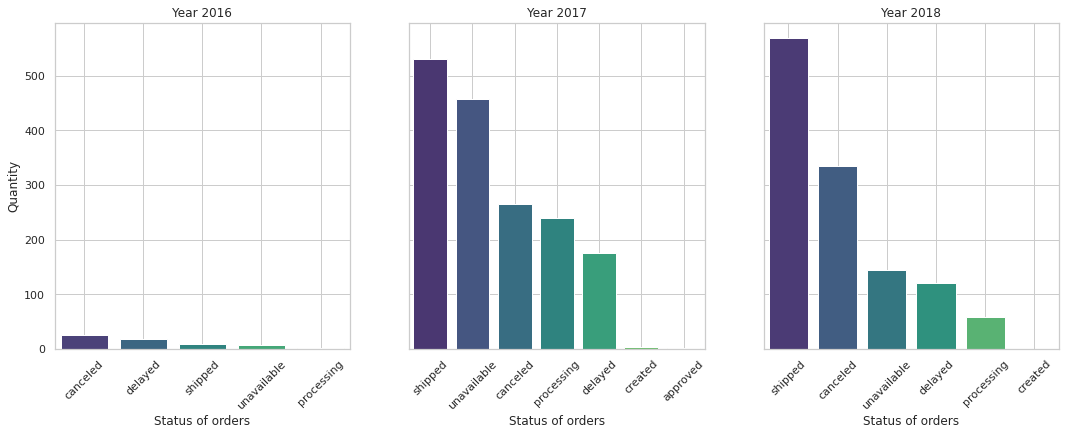

In [0]:
#status of orders per year 
undelivered_filtered_df = undelivered_df.filter(undelivered_df['order_status'] != 'delivered') #excluding 'delivered' for better readness
undelivered_pd_df = undelivered_filtered_df.toPandas()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)

years = undelivered_pd_df['year'].unique()
for i, year in enumerate(years):
    data = undelivered_pd_df[undelivered_pd_df['year'] == year]
    ax = axes[i]
    sns.barplot(data=data, x='order_status', y='qty', ax=ax, palette="viridis")
    ax.set_xlabel('Status of orders')
    if i == 0:  # tylko pierwszy subplot potrzebuje etykiety osi Y
        ax.set_ylabel('Quantity')
    else:
        ax.set_ylabel('')
    ax.set_title(f'Year {year}')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

plt.show()

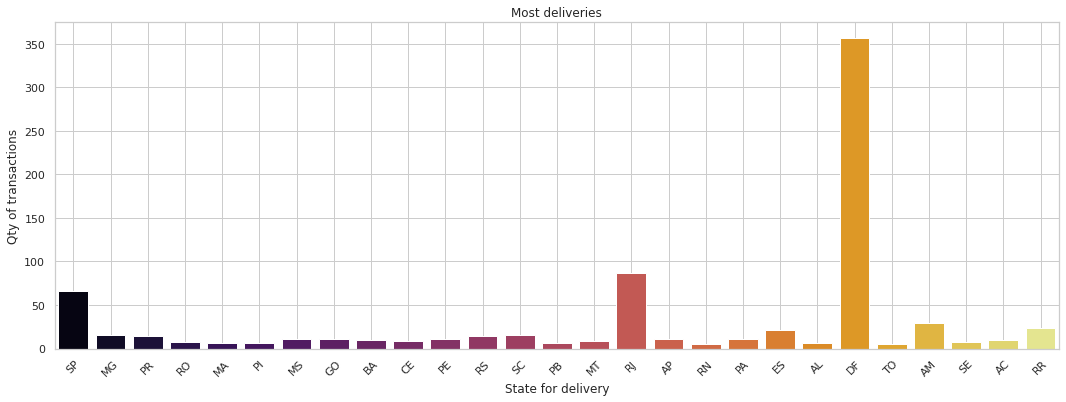

In [0]:
#best destinations - states
best_dest_pd_df = best_dest_df.toPandas()

plt.figure(figsize=(18, 6))
sns.barplot(data=best_dest_pd_df, x='customer_state', y='qty', palette="inferno", ci=None)

plt.xlabel('State for delivery')
plt.ylabel('Qty of transactions')
plt.title('Most deliveries')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()